In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
from sklearn.cluster import KMeans
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import imp
import ucl_v2
import utilities # this file must be in the same folder as the notebook
import seaborn as sns
import umap
import umap.plot

In [9]:
# # This enables reproducible results
# tf.keras.utils.set_random_seed(101)
# tf.config.experimental.enable_op_determinism()
#### os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
tf.keras.backend.clear_session
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="5"; 

In [10]:
# Constants used for learning
WORK_IMG_SIZE = 112, 112 # Note: (224, 224) is default for most pretrained models
INPUT_SHAPE = WORK_IMG_SIZE + (3,) # 3 for rgb, since model is pretrained for color images
BATCH_SIZE = 16
CLUSTERS = 4
# dt = datetime.now()
# timestamp = str(dt)[:str(dt).find(".")].replace("-", "").replace(":", "").replace(" ", "_")  # use for log file name

STORE_Path = "Results/Res_Fold1"
CHECKPOINTS_Path = STORE_Path+"/checkpoints/"
LOGS_Path = STORE_Path+"/"
PLOTS_Path = STORE_Path+"/plots/"

# create directories
if not os.path.isdir(CHECKPOINTS_Path):
    os.makedirs(CHECKPOINTS_Path)
if not os.path.isdir(PLOTS_Path):
    os.makedirs(PLOTS_Path)

In [11]:
# Data Generator for feature extraction (only standardization, no randomness)
ext_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                            samplewise_center=True, #False,
                                            samplewise_std_normalization=True #False
                                        )

# This one is for the training (contains randomized augmentations)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                            samplewise_center=True, #False,
                                            samplewise_std_normalization=True, #False,
                                            rotation_range=30, # 0,
                                            brightness_range=None, # ?
                                            shear_range=0.1, # 0.0,
                                            zoom_range=0.1, # 0.0,
                                            channel_shift_range=0.0,
                                            fill_mode='nearest',
                                            cval=0.0,
                                            horizontal_flip=True, # False,
                                            vertical_flip=True, # False,
                                        )

In [12]:
!pwd

/home/nosabi/Nosheen/UCL-Multiclass/EuroSAT/Unsupervised


### UCL

In [13]:
# Load data
# Expects text files where each line contains a path and a label, separated by space

data_path = "/home/nosabi/Nosheen/UCL-Multiclass/EuroSAT_paths_4cls.txt"
all_paths_df = utilities.make_path_df([data_path])

train_df, test_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)
# valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=4444)

# train_df = utilities.make_path_df(["mnist_train.txt"])
X_train = train_df['path']
y_train = train_df['label']

# # Replace labels with integers. Keep names for future use.
label_names = train_df["label"].unique()
label_dict = {}
for e,l in enumerate(label_names): label_dict[l] = e
train_df["label"].replace(label_dict, inplace=True) 

# test_df = utilities.make_path_df(["mnist_test.txt"])
X_test = test_df['path']
y_test = test_df['label']

# # Replace labels with integers. Keep names for future use.
label_names = test_df["label"].unique()
label_dict = {}
for e,l in enumerate(label_names): label_dict[l] = e
test_df["label"].replace(label_dict, inplace=True) 
label_dict = {v: k for k, v in label_dict.items()}

print(f"Training data: {len(X_train)}\nTesting data: {len(X_test)}")
print("Unique labels: ",label_names, len(label_names))
print(y_train.value_counts())
print(y_test.value_counts())

Training data: 8800
Testing data: 2200
Unique labels:  ['Forest' 'SeaLake' 'Pasture' 'Residential'] 4
0    2446
2    2411
3    2385
1    1558
Name: label, dtype: int64
3    615
1    589
0    554
2    442
Name: label, dtype: int64


/home/nosabi/anaconda3/envs/wasabi/lib/python3.6/site-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [14]:
# Create model. Remember to rerun this before running the next cell
# vgg16model = ucl_v2.create_model(tf.keras.applications.vgg16.VGG16, weights="imagenet", input_shape=INPUT_SHAPE,
#                               #core_output_layer="block3_pool", # here you can set a different output layer
#                               n_clusters=CLUSTERS,
#                               learning_rate=0.00000001, momentum=0, # never actually used, model is recompiled later
#                               random_seed=101)
# vgg16model.save(CHECKPOINTS_Path + '0.ckpt')
vgg16model = tf.keras.models.load_model(CHECKPOINTS_Path + '0.ckpt')

In [15]:
vgg16model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0     

In [ ]:
# import ucl
imp.reload(ucl_v2)

# please read "read me" file in the folder to understand the parameters settings
mod, i_metrics, pl, sims, hists = ucl_v2.make_ucl(vgg16model,
                                           data=X_train,
                                           true_labels=y_train,
                                           ext_datagen=ext_datagen,
                                           train_datagen=train_datagen,
                                           img_size=WORK_IMG_SIZE,
                                           starting_centers=None,
                                           freeze_centers=False,
                                           use_previous_centers=False,
                                           random_seed=101,
                                           freeze_layers=0,
                                           elambda="auto",
                                           learning_rate=0.0001, momentum=0.9,
                                           n_clusters=CLUSTERS, start_iter=1, stop_iter=20 , n_epochs=50,
                                           use_validation=True,
                                           log_path=LOGS_Path,
                                           checkpoint_path=CHECKPOINTS_Path,
                                           plots_path=PLOTS_Path,
                                           comment="")
i_metrics.head(12)

In [10]:
i_metrics

,ss_dists,purity,silhouette,reliable,chgd_lbls,n_in_0,rel_in_0,n_in_1,rel_in_1,n_in_2,rel_in_2,n_in_3,rel_in_3,epochs
1,2.89646e+06,0.766193,0.110759,1056,0,2680,264,2236,264,1531,264,2353,264,13
2,1.31633e+07,0.767614,0.298378,2112,286,2646,528,2225,528,1583,528,2346,528,21
3,1.48915e+07,0.767614,0.314546,3168,26,2646,792,2226,792,1586,792,2342,792,15
4,1.4707e+07,0.768239,0.338202,4224,71,2687,1056,2194,1056,1568,1056,2351,1056,24
5,1.62363e+07,0.768466,0.352191,4668,27,2701,1167,2194,1167,1557,1167,2348,1167,10
6,1.76162e+07,0.76875,0.359018,4644,22,2706,1161,2195,1161,1549,1161,2350,1161,9
7,1.78837e+07,0.769318,0.361461,4656,48,2715,1164,2171,1164,1553,1164,2361,1164,13
8,1.86624e+07,0.769489,0.366043,4624,34,2718,1156,2180,1156,1542,1156,2360,1156,7
9,1.94082e+07,0.769261,0.365439,4656,21,2707,1164,2181,1164,1553,1164,2359,1164,7
10,1.45213e+07,0.770057,0.345674,4568,76,2753,1142,2165,1142,1523,1142,2359,1142,14


In [ ]:
for c in i_metrics.columns:
    plt.figure(figsize=(6,3))
    i_metrics[c].plot(title=c)
    plt.ylim(bottom=0, top=max(1.1, max(i_metrics[c])+0.2))
    plt.tight_layout()
    plt.savefig(PLOTS_Path+f"histories_{c}.jpg") # for some reason, tight layout doesn't work with png
    plt.show()

In [8]:
import imp
imp.reload(ucl_v2)

from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
for i in range(0,22):
    print("*****************************************")
    print("******** ITERATION "+str(i)+" ************")
    eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

    preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
    print(preds_df.value_counts("correct_p"))
    # print(preds_df.value_counts("correct_c"))

    print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
    f = open(LOGS_Path+"rep_p_it_"+str(i)+".txt", "w")
    f.write(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
    f.close()

    print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
    # print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
    print("*****************************************")

*****************************************
******** ITERATION 0 ************
Found 2200 validated image filenames belonging to 1 classes.
[(1, 0), (3, 2), (2, 3), (0, 1)]
correct_p
False    1563
True      637
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.2895
               Precision Recall  F1-score Support
 Forest         0.0000   0.0000   0.0000   554     
 SeaLake        0.2813   0.9270   0.4316   589     
 Pasture        0.6111   0.0747   0.1331   442     
 Residential    0.3240   0.0943   0.1461   615     
 macro avg      0.3041   0.2740   0.1777   2200  
 weighted avg   0.2887   0.2895   0.1831   2200  
[[  0 508   0  46]
 [  4 546   1  38]
 [ 16 356  33  37]
 [  6 531  20  58]]
*****************************************
*****************************************
******** ITERATION 1 ************
Found 2200 validated image filenames belonging to 1 classes.
[(0, 0), (1, 1), (2, 2), (3, 3)]
correct_p
True     1792
False     408
dtype: int64
+-----------

*****************************************
******** ITERATION 8 ************
Found 2200 validated image filenames belonging to 1 classes.
[(0, 0), (1, 1), (2, 2), (3, 3)]
correct_p
True     2056
False     144
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.9345
               Precision Recall  F1-score Support
 Forest         0.8805   0.9314   0.9053   554     
 SeaLake        0.9940   0.8506   0.9167   589     
 Pasture        0.8653   0.9887   0.9229   442     
 Residential    0.9950   0.9789   0.9869   615     
 macro avg      0.9337   0.9374   0.9330   2200  
 weighted avg   0.9399   0.9345   0.9347   2200  
[[516   2  35   1]
 [ 60 501  27   1]
 [  3   1 437   1]
 [  7   0   6 602]]
*****************************************


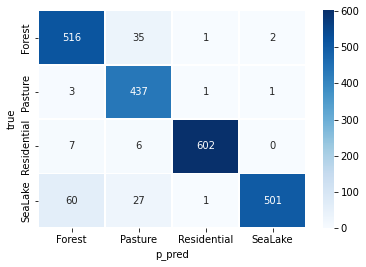

In [9]:
i = 8
print("*****************************************")
print("******** ITERATION "+str(i)+" ************")
eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
print(preds_df.value_counts("correct_p"))
# print(preds_df.value_counts("correct_c"))

print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))

print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
# print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
print("*****************************************")


preds_df["true"] = [label_dict[x] for x in preds_df["true"]] 
preds_df["p_pred"] = [label_dict[x] for x in preds_df["p_pred"]] 

preds_df["correct_p"] = preds_df["p_pred"] == preds_df["true"]
misclassified = preds_df[preds_df["correct_p"] == False]

cm = pd.crosstab(preds_df["true"], preds_df["p_pred"])
f = sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues', linewidth=.5)

*****************************************
******** ITERATION 0 ************
Found 2200 validated image filenames belonging to 1 classes.
[(1, 0), (3, 2), (2, 3), (0, 1)]
correct_p
False    1563
True      637
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.2895
               Precision Recall  F1-score Support
 Forest         0.0000   0.0000   0.0000   554     
 SeaLake        0.2813   0.9270   0.4316   589     
 Pasture        0.6111   0.0747   0.1331   442     
 Residential    0.3240   0.0943   0.1461   615     
 macro avg      0.3041   0.2740   0.1777   2200  
 weighted avg   0.2887   0.2895   0.1831   2200  
[[  0 508   0  46]
 [  4 546   1  38]
 [ 16 356  33  37]
 [  6 531  20  58]]
*****************************************


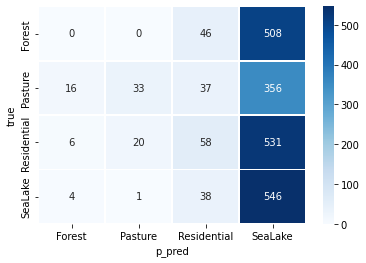

In [16]:


# RANDOM FC


i = 0
print("*****************************************")
print("******** ITERATION "+str(i)+" ************")
eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
print(preds_df.value_counts("correct_p"))
# print(preds_df.value_counts("correct_c"))

print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))

print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
# print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
print("*****************************************")


preds_df["true"] = [label_dict[x] for x in preds_df["true"]] 
preds_df["p_pred"] = [label_dict[x] for x in preds_df["p_pred"]] 

preds_df["correct_p"] = preds_df["p_pred"] == preds_df["true"]
misclassified = preds_df[preds_df["correct_p"] == False]

cm = pd.crosstab(preds_df["true"], preds_df["p_pred"])
f = sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues', linewidth=.5)

*****************************************
******** ITERATION 0 ************
Found 2200 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (2200, 4608)
Number of classes in the test set: 4
Clustering features into 4 clusters...using random clustering...done!
[(1, 1), (2, 0), (3, 3), (0, 2)]
correct_p
True     1369
False     831
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.6223
               Precision Recall  F1-score Support
 Forest         0.0000   0.0000   0.0000   554     
 SeaLake        0.5138   0.9813   0.6744   589     
 Pasture        0.8996   0.9321   0.9156   442     
 Residential    0.9571   0.6163   0.7498   615     
 macro avg      0.5926   0.6324   0.5849   2200  
 weighted avg   0.5858   0.6223   0.5741   2200  
[[  0 520  26   8]
 [  0 578  11   0]
 [  4  17 412   9]
 [217  10   9 379]]
*****************************************


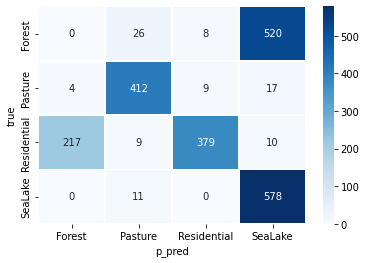

In [35]:
### CLUSTERING

import imp
imp.reload(ucl_v2)
i = 0                                                                   
print("*****************************************")
print("******** ITERATION "+str(i)+" ************")
eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")
preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE, is_clustering=True)
print(preds_df.value_counts("correct_p"))
# print(preds_df.value_counts("correct_c"))

print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))

print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
# print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
print("*****************************************")


preds_df["true"] = [label_dict[x] for x in preds_df["true"]] 
preds_df["p_pred"] = [label_dict[x] for x in preds_df["p_pred"]] 

preds_df["correct_p"] = preds_df["p_pred"] == preds_df["true"]
misclassified = preds_df[preds_df["correct_p"] == False]

cm = pd.crosstab(preds_df["true"], preds_df["p_pred"])
f = sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues', linewidth=.5)

# Cross Domain

### SAT6

In [5]:
# Load data
# Expects text files where each line contains a path and a label, separated by space

data_path = "/home/nosabi/Nosheen/UCL-Multiclass/SAT6_paths_4cls.txt"
all_paths_df = utilities.make_path_df([data_path])

_, test_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)
# valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=4444)

# test_df = utilities.make_path_df(["mnist_test.txt"])
X_test = test_df['path']
y_test = test_df['label']

# # Replace labels with integers. Keep names for future use.
label_names = test_df["label"].unique()
label_dict = {}
for e,l in enumerate(label_names): label_dict[l] = e
test_df["label"].replace(label_dict, inplace=True) 
label_dict = {v: k for k, v in label_dict.items()}

print(f"Testing data: {len(X_test)}")
print("Unique labels: ",label_names, len(label_names))
print(y_test.value_counts())

Testing data: 4000
Unique labels:  ['water' 'trees' 'building' 'grassland'] 4
0    1043
1    1026
3     971
2     960
Name: label, dtype: int64


/home/nosabi/anaconda3/envs/wasabi/lib/python3.6/site-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [8]:
import imp
imp.reload(ucl_v2)

from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
for i in range(0,22):
    print("*****************************************")
    print("******** ITERATION "+str(i)+" ************")
    eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

    preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
    print(preds_df.value_counts("correct_p"))
    # print(preds_df.value_counts("correct_c"))

    print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
    
    print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
    # print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
    print("*****************************************")

*****************************************
******** ITERATION 0 ************
Found 4000 validated image filenames belonging to 1 classes.
[(0, 0), (2, 1), (3, 3), (1, 2)]
correct_p
False    2801
True     1199
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.2998
               Precision Recall  F1-score Support
 water          0.2806   0.9760   0.4359   1043    
 trees          0.2083   0.0292   0.0513   1026    
 building       0.8889   0.0667   0.1240   960     
 grassland      0.5577   0.0896   0.1544   971     
 macro avg      0.4839   0.2904   0.1914   4000  
 weighted avg   0.4753   0.2998   0.1941   4000  
[[1018   25    0    0]
 [ 939   30    2   55]
 [ 844   38   64   14]
 [ 827   51    6   87]]
*****************************************
*****************************************
******** ITERATION 1 ************
Found 4000 validated image filenames belonging to 1 classes.
[(0, 0), (2, 1), (3, 3), (1, 2)]
correct_p
False    2801
True     1199
dtype: in

*****************************************
******** ITERATION 19 ************
Found 4000 validated image filenames belonging to 1 classes.
[(0, 3), (2, 2), (3, 0), (1, 1)]
correct_p
False    2150
True     1850
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.4625
               Precision Recall  F1-score Support
 water          0.3426   1.0000   0.5104   1043    
 trees          0.0122   0.0010   0.0018   1026    
 building       0.9203   0.8177   0.8660   960     
 grassland      1.0000   0.0216   0.0423   971     
 macro avg      0.5688   0.4601   0.3551   4000  
 weighted avg   0.5561   0.4625   0.3517   4000  
[[1043    0    0    0]
 [1009    1   16    0]
 [ 102   73  785    0]
 [ 890    8   52   21]]
*****************************************


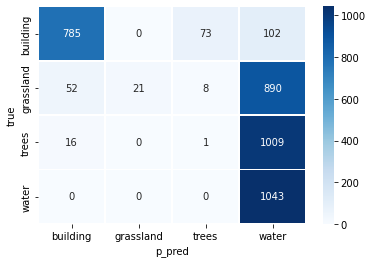

In [6]:
i = 19
print("*****************************************")
print("******** ITERATION "+str(i)+" ************")
eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
print(preds_df.value_counts("correct_p"))
# print(preds_df.value_counts("correct_c"))

print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))

print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
# print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
print("*****************************************")


preds_df["true"] = [label_dict[x] for x in preds_df["true"]] 
preds_df["p_pred"] = [label_dict[x] for x in preds_df["p_pred"]] 

preds_df["correct_p"] = preds_df["p_pred"] == preds_df["true"]
misclassified = preds_df[preds_df["correct_p"] == False]

cm = pd.crosstab(preds_df["true"], preds_df["p_pred"])
f = sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues', linewidth=.5)

## RSSCN7

### RSSCN7 1 Res

In [18]:
# Load data
# Expects text files where each line contains a path and a label, separated by space

data_path = "/home/nosabi/Nosheen/UCL-Multiclass/RSSCN7_paths_4cls_1reslotion.txt"
all_paths_df = utilities.make_path_df([data_path])

_, test_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)
# valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=4444)

# test_df = utilities.make_path_df(["mnist_test.txt"])
X_test = test_df['path']
y_test = test_df['label']

# # Replace labels with integers. Keep names for future use.
label_names = test_df["label"].unique()
label_dict = {}
for e,l in enumerate(label_names): label_dict[l] = e
test_df["label"].replace(label_dict, inplace=True) 
label_dict = {v: k for k, v in label_dict.items()}

print(f"Testing data: {len(X_test)}")
print("Unique labels: ",label_names, len(label_names))
print(y_test.value_counts())

Testing data: 80
Unique labels:  ['Forest' 'RiverLake' 'Grass' 'Resident'] 4
1    25
0    25
3    17
2    13
Name: label, dtype: int64


/home/nosabi/anaconda3/envs/wasabi/lib/python3.6/site-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [19]:
import imp
imp.reload(ucl_v2)

from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
for i in range(0,22):
    print("*****************************************")
    print("******** ITERATION "+str(i)+" ************")
    eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

    preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
    print(preds_df.value_counts("correct_p"))
    # print(preds_df.value_counts("correct_c"))

    print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
    
    print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
    # print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
    print("*****************************************")

*****************************************
******** ITERATION 0 ************
Found 80 validated image filenames belonging to 1 classes.
[(1, 0), (0, 2), (3, 3), (2, 1)]
correct_p
False    51
True     29
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.3625
               Precision Recall  F1-score Support
 Forest         0.4375   0.2800   0.3415   25      
 RiverLake      0.3393   0.7600   0.4691   25      
 Grass          0.0000   0.0000   0.0000   13      
 Resident       0.6000   0.1765   0.2727   17      
 macro avg      0.3442   0.3041   0.2708   80  
 weighted avg   0.3702   0.3625   0.3113   80  
[[ 7 17  0  1]
 [ 2 19  3  1]
 [ 7  6  0  0]
 [ 0 14  0  3]]
*****************************************
*****************************************
******** ITERATION 1 ************
Found 80 validated image filenames belonging to 1 classes.
[(1, 0), (0, 2), (3, 3), (2, 1)]
correct_p
False    51
True     29
dtype: int64
+------------- CLASSIFICATION REPORT -------

*****************************************
******** ITERATION 3 ************
Found 80 validated image filenames belonging to 1 classes.
[(0, 3), (1, 2), (2, 0), (3, 1)]
correct_p
False    43
True     37
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.4625
               Precision Recall  F1-score Support
 Forest         0.4688   0.6000   0.5263   25      
 RiverLake      0.4773   0.8400   0.6087   25      
 Grass          0.5000   0.0769   0.1333   13      
 Resident       0.0000   0.0000   0.0000   17      
 macro avg      0.3615   0.3792   0.3171   80  
 weighted avg   0.3769   0.4625   0.3764   80  
[[15 10  0  0]
 [ 1 21  1  2]
 [ 1 11  1  0]
 [15  2  0  0]]
*****************************************


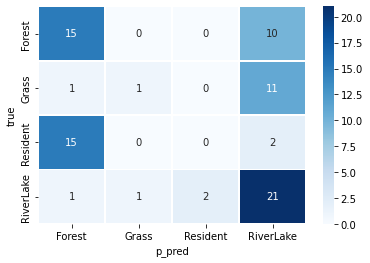

In [20]:
i = 3
print("*****************************************")
print("******** ITERATION "+str(i)+" ************")
eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
print(preds_df.value_counts("correct_p"))
# print(preds_df.value_counts("correct_c"))

print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))

print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
# print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
print("*****************************************")


preds_df["true"] = [label_dict[x] for x in preds_df["true"]] 
preds_df["p_pred"] = [label_dict[x] for x in preds_df["p_pred"]] 

preds_df["correct_p"] = preds_df["p_pred"] == preds_df["true"]
misclassified = preds_df[preds_df["correct_p"] == False]

cm = pd.crosstab(preds_df["true"], preds_df["p_pred"])
f = sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues', linewidth=.5)

### RSSCN7 2 Res

In [15]:
# Load data
# Expects text files where each line contains a path and a label, separated by space

data_path = "/home/nosabi/Nosheen/UCL-Multiclass/RSSCN7_paths_4cls_2reslotion.txt"
all_paths_df = utilities.make_path_df([data_path])

_, test_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)
# valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=4444)

# test_df = utilities.make_path_df(["mnist_test.txt"])
X_test = test_df['path']
y_test = test_df['label']

# # Replace labels with integers. Keep names for future use.
label_names = test_df["label"].unique()
label_dict = {}
for e,l in enumerate(label_names): label_dict[l] = e
test_df["label"].replace(label_dict, inplace=True) 
label_dict = {v: k for k, v in label_dict.items()}

print(f"Testing data: {len(X_test)}")
print("Unique labels: ",label_names, len(label_names))
print(y_test.value_counts())

Testing data: 80
Unique labels:  ['Forest' 'RiverLake' 'Grass' 'Resident'] 4
1    25
0    25
3    17
2    13
Name: label, dtype: int64


/home/nosabi/anaconda3/envs/wasabi/lib/python3.6/site-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [16]:
import imp
imp.reload(ucl_v2)

from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
for i in range(0,22):
    print("*****************************************")
    print("******** ITERATION "+str(i)+" ************")
    eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

    preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
    print(preds_df.value_counts("correct_p"))
    # print(preds_df.value_counts("correct_c"))

    print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
    
    print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
    # print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
    print("*****************************************")

*****************************************
******** ITERATION 0 ************
Found 80 validated image filenames belonging to 1 classes.
[(0, 0), (1, 2), (2, 3), (3, 1)]
correct_p
False    59
True     21
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.2625
               Precision Recall  F1-score Support
 Forest         0.3023   0.5200   0.3824   25      
 RiverLake      0.2857   0.2400   0.2609   25      
 Grass          0.1538   0.1538   0.1538   13      
 Resident       0.0000   0.0000   0.0000   17      
 macro avg      0.1855   0.2285   0.1993   80  
 weighted avg   0.2088   0.2625   0.2260   80  
[[13  9  3  0]
 [11  6  6  2]
 [ 6  4  2  1]
 [13  2  2  0]]
*****************************************
*****************************************
******** ITERATION 1 ************
Found 80 validated image filenames belonging to 1 classes.
[(0, 0), (1, 2), (2, 3), (3, 1)]
correct_p
False    59
True     21
dtype: int64
+------------- CLASSIFICATION REPORT -------

*****************************************
******** ITERATION 3 ************
Found 80 validated image filenames belonging to 1 classes.
[(1, 2), (3, 3), (0, 0), (2, 1)]
correct_p
False    43
True     37
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.4625
               Precision Recall  F1-score Support
 Forest         1.0000   0.1200   0.2143   25      
 RiverLake      0.4722   0.6800   0.5574   25      
 Grass          0.0000   0.0000   0.0000   13      
 Resident       0.4595   1.0000   0.6296   17      
 macro avg      0.4829   0.4500   0.3503   80  
 weighted avg   0.5577   0.4625   0.3749   80  
[[ 3  8  0 14]
 [ 0 17  4  4]
 [ 0 11  0  2]
 [ 0  0  0 17]]
*****************************************


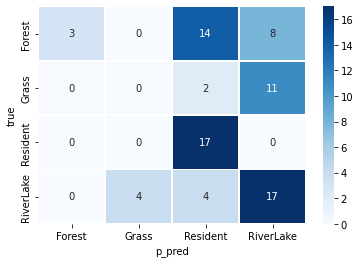

In [17]:
i = 3
print("*****************************************")
print("******** ITERATION "+str(i)+" ************")
eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
print(preds_df.value_counts("correct_p"))
# print(preds_df.value_counts("correct_c"))

print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))

print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
# print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
print("*****************************************")


preds_df["true"] = [label_dict[x] for x in preds_df["true"]] 
preds_df["p_pred"] = [label_dict[x] for x in preds_df["p_pred"]] 

preds_df["correct_p"] = preds_df["p_pred"] == preds_df["true"]
misclassified = preds_df[preds_df["correct_p"] == False]

cm = pd.crosstab(preds_df["true"], preds_df["p_pred"])
f = sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues', linewidth=.5)

### RSSCN7 3 Res

In [12]:
# Load data
# Expects text files where each line contains a path and a label, separated by space

data_path = "/home/nosabi/Nosheen/UCL-Multiclass/RSSCN7_paths_4cls_3reslotion.txt"
testall_paths_df_df = utilities.make_path_df([data_path])

_, test_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)
# valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=4444)

# test_df = utilities.make_path_df(["mnist_test.txt"])
X_test = test_df['path']
y_test = test_df['label']

# # Replace labels with integers. Keep names for future use.
label_names = test_df["label"].unique()
label_dict = {}
for e,l in enumerate(label_names): label_dict[l] = e
test_df["label"].replace(label_dict, inplace=True) 
label_dict = {v: k for k, v in label_dict.items()}

print(f"Testing data: {len(X_test)}")
print("Unique labels: ",label_names, len(label_names))
print(y_test.value_counts())

Testing data: 80
Unique labels:  ['Forest' 'RiverLake' 'Grass' 'Resident'] 4
1    25
0    25
3    17
2    13
Name: label, dtype: int64


/home/nosabi/anaconda3/envs/wasabi/lib/python3.6/site-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [13]:
import imp
imp.reload(ucl_v2)

from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
for i in range(0,22):
    print("*****************************************")
    print("******** ITERATION "+str(i)+" ************")
    eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

    preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
    print(preds_df.value_counts("correct_p"))
    # print(preds_df.value_counts("correct_c"))

    print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
    
    print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
    # print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
    print("*****************************************")

*****************************************
******** ITERATION 0 ************
Found 80 validated image filenames belonging to 1 classes.
[(0, 0), (1, 2), (3, 3), (2, 1)]
correct_p
False    54
True     26
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.325
               Precision Recall  F1-score Support
 Forest         0.3256   0.5600   0.4118   25      
 RiverLake      0.4211   0.3200   0.3636   25      
 Grass          0.0000   0.0000   0.0000   13      
 Resident       0.2667   0.2353   0.2500   17      
 macro avg      0.2533   0.2788   0.2564   80  
 weighted avg   0.2900   0.3250   0.2954   80  
[[14  5  1  5]
 [11  8  2  4]
 [10  1  0  2]
 [ 8  5  0  4]]
*****************************************
*****************************************
******** ITERATION 1 ************
Found 80 validated image filenames belonging to 1 classes.
[(0, 0), (1, 2), (3, 3), (2, 1)]
correct_p
False    54
True     26
dtype: int64
+------------- CLASSIFICATION REPORT --------

*****************************************
******** ITERATION 3 ************
Found 80 validated image filenames belonging to 1 classes.
[(1, 2), (3, 3), (0, 0), (2, 1)]
correct_p
False    43
True     37
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.4625
               Precision Recall  F1-score Support
 Forest         1.0000   0.0400   0.0769   25      
 RiverLake      0.4231   0.8800   0.5714   25      
 Grass          0.0000   0.0000   0.0000   13      
 Resident       0.5185   0.8235   0.6364   17      
 macro avg      0.4854   0.4359   0.3212   80  
 weighted avg   0.5549   0.4625   0.3378   80  
[[ 1 14  0 10]
 [ 0 22  0  3]
 [ 0 13  0  0]
 [ 0  3  0 14]]
*****************************************


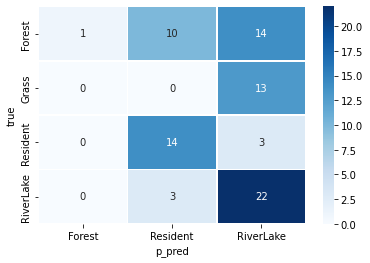

In [14]:
i = 3
print("*****************************************")
print("******** ITERATION "+str(i)+" ************")
eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
print(preds_df.value_counts("correct_p"))
# print(preds_df.value_counts("correct_c"))

print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))

print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
# print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
print("*****************************************")


preds_df["true"] = [label_dict[x] for x in preds_df["true"]] 
preds_df["p_pred"] = [label_dict[x] for x in preds_df["p_pred"]] 

preds_df["correct_p"] = preds_df["p_pred"] == preds_df["true"]
misclassified = preds_df[preds_df["correct_p"] == False]

cm = pd.crosstab(preds_df["true"], preds_df["p_pred"])
f = sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues', linewidth=.5)

### RSSCN7 4 Res

In [24]:
# Load data
# Expects text files where each line contains a path and a label, separated by space

data_path = "/home/nosabi/Nosheen/UCL-Multiclass/RSSCN7_paths_4cls_4reslotion.txt"
all_paths_df = utilities.make_path_df([data_path])

_, test_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)
# valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=4444)

# test_df = utilities.make_path_df(["mnist_test.txt"])
X_test = test_df['path']
y_test = test_df['label']

# # Replace labels with integers. Keep names for future use.
label_names = test_df["label"].unique()
label_dict = {}
for e,l in enumerate(label_names): label_dict[l] = e
test_df["label"].replace(label_dict, inplace=True) 
label_dict = {v: k for k, v in label_dict.items()}

print(f"Testing data: {len(X_test)}")
print("Unique labels: ",label_names, len(label_names))
print(y_test.value_counts())

Testing data: 80
Unique labels:  ['Forest' 'RiverLake' 'Grass' 'Resident'] 4
1    25
0    25
3    17
2    13
Name: label, dtype: int64


/home/nosabi/anaconda3/envs/wasabi/lib/python3.6/site-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [10]:
import imp
imp.reload(ucl_v2)

from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
for i in range(0,22):
    print("*****************************************")
    print("******** ITERATION "+str(i)+" ************")
    eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

    preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
    print(preds_df.value_counts("correct_p"))
    # print(preds_df.value_counts("correct_c"))

    print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
    
    print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
    # print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
    print("*****************************************")

*****************************************
******** ITERATION 0 ************
Found 80 validated image filenames belonging to 1 classes.
[(0, 0), (1, 2), (3, 3), (2, 1)]
correct_p
False    54
True     26
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.325
               Precision Recall  F1-score Support
 Forest         0.3256   0.5600   0.4118   25      
 RiverLake      0.4211   0.3200   0.3636   25      
 Grass          0.0000   0.0000   0.0000   13      
 Resident       0.2667   0.2353   0.2500   17      
 macro avg      0.2533   0.2788   0.2564   80  
 weighted avg   0.2900   0.3250   0.2954   80  
[[14  5  1  5]
 [11  8  2  4]
 [10  1  0  2]
 [ 8  5  0  4]]
*****************************************
*****************************************
******** ITERATION 1 ************
Found 80 validated image filenames belonging to 1 classes.
[(0, 0), (1, 2), (3, 3), (2, 1)]
correct_p
False    54
True     26
dtype: int64
+------------- CLASSIFICATION REPORT --------

*****************************************
******** ITERATION 9 ************
Found 80 validated image filenames belonging to 1 classes.
[(1, 2), (3, 3), (0, 0), (2, 1)]
correct_p
False    41
True     39
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.4875
               Precision Recall  F1-score Support
 Forest         1.0000   0.0400   0.0769   25      
 RiverLake      0.4583   0.8800   0.6027   25      
 Grass          0.0000   0.0000   0.0000   13      
 Resident       0.5161   0.9412   0.6667   17      
 macro avg      0.4936   0.4653   0.3366   80  
 weighted avg   0.5654   0.4875   0.3541   80  
[[ 1 12  0 12]
 [ 0 22  0  3]
 [ 0 13  0  0]
 [ 0  1  0 16]]
*****************************************


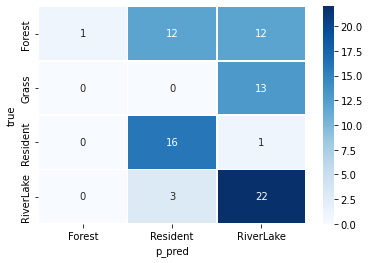

In [26]:
i = 9

print("*****************************************")
print("******** ITERATION "+str(i)+" ************")
eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
print(preds_df.value_counts("correct_p"))
# print(preds_df.value_counts("correct_c"))

print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))

print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
# print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
print("*****************************************")


preds_df["true"] = [label_dict[x] for x in preds_df["true"]] 
preds_df["p_pred"] = [label_dict[x] for x in preds_df["p_pred"]] 

preds_df["correct_p"] = preds_df["p_pred"] == preds_df["true"]
misclassified = preds_df[preds_df["correct_p"] == False]

cm = pd.crosstab(preds_df["true"], preds_df["p_pred"])
f = sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues', linewidth=.5)

### RSSCN7 all resolutions

In [6]:
# Load data
# Expects text files where each line contains a path and a label, separated by space

data_path = "/home/nosabi/Nosheen/UCL-Multiclass/RSSCN7_paths_4cls.txt"
all_paths_df = utilities.make_path_df([data_path])

_, test_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)
# valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=4444)

# test_df = utilities.make_path_df(["mnist_test.txt"])
X_test = test_df['path']
y_test = test_df['label']

# # Replace labels with integers. Keep names for future use.
label_names = test_df["label"].unique()
label_dict = {}
for e,l in enumerate(label_names): label_dict[l] = e
test_df["label"].replace(label_dict, inplace=True) 
label_dict = {v: k for k, v in label_dict.items()}

print(f"Testing data: {len(X_test)}")
print("Unique labels: ",label_names, len(label_names))
print(y_test.value_counts())

Testing data: 320
Unique labels:  ['Resident' 'Forest' 'Grass' 'RiverLake'] 4
0    91
1    78
3    77
2    74
Name: label, dtype: int64


/home/nosabi/anaconda3/envs/wasabi/lib/python3.6/site-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
import imp
imp.reload(ucl_v2)

from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
for i in range(0,22):
    print("*****************************************")
    print("******** ITERATION "+str(i)+" ************")
    eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

    preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
    print(preds_df.value_counts("correct_p"))
    # print(preds_df.value_counts("correct_c"))

    print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
    
    print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
    # print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
    print("*****************************************")

*****************************************
******** ITERATION 3 ************
Found 320 validated image filenames belonging to 1 classes.
[(0, 3), (2, 2), (1, 0), (3, 1)]
correct_p
True     162
False    158
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.5062
               Precision Recall  F1-score Support
 Resident       0.6131   0.9231   0.7368   91      
 Forest         0.7273   0.1026   0.1798   78      
 Grass          0.3892   0.8784   0.5394   74      
 RiverLake      1.0000   0.0649   0.1220   77      
 macro avg      0.6824   0.4922   0.3945   320  
 weighted avg   0.6823   0.5062   0.4074   320  
[[84  0  7  0]
 [37  8 33  0]
 [ 8  1 65  0]
 [ 8  2 62  5]]
*****************************************


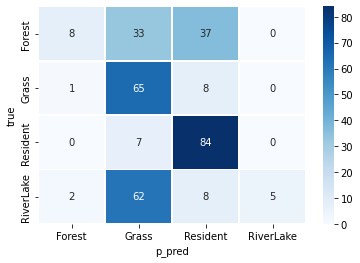

In [8]:
i = 3
print("*****************************************")
print("******** ITERATION "+str(i)+" ************")
eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
print(preds_df.value_counts("correct_p"))
# print(preds_df.value_counts("correct_c"))

print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))

print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
# print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
print("*****************************************")


preds_df["true"] = [label_dict[x] for x in preds_df["true"]] 
preds_df["p_pred"] = [label_dict[x] for x in preds_df["p_pred"]] 

preds_df["correct_p"] = preds_df["p_pred"] == preds_df["true"]
misclassified = preds_df[preds_df["correct_p"] == False]

cm = pd.crosstab(preds_df["true"], preds_df["p_pred"])
f = sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues', linewidth=.5)

## UCMerced_Landuse

In [10]:
# Load data
# Expects text files where each line contains a path and a label, separated by space

data_path = "/home/nosabi/Nosheen/UCL-Multiclass/UCMerced_LandUse_paths_4cls.txt"
test_df = utilities.make_path_df([data_path])

# test_df = utilities.make_path_df(["mnist_test.txt"])
X_test = test_df['path']
y_test = test_df['label']

# # Replace labels with integers. Keep names for future use.
label_names = test_df["label"].unique()
label_dict = {}
for e,l in enumerate(label_names): label_dict[l] = e
test_df["label"].replace(label_dict, inplace=True) 
label_dict = {v: k for k, v in label_dict.items()}

print(f"Testing data: {len(X_test)}")
print("Unique labels: ",label_names, len(label_names))
print(y_test.value_counts())

Testing data: 400
Unique labels:  ['golfcourse' 'river' 'forest' 'buildings'] 4
3    100
2    100
1    100
0    100
Name: label, dtype: int64


In [11]:
import imp
imp.reload(ucl_v2)

from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
for i in range(0,22):
    print("*****************************************")
    print("******** ITERATION "+str(i)+" ************")
    eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

    preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
    print(preds_df.value_counts("correct_p"))
    # print(preds_df.value_counts("correct_c"))

    print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
    
    print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
    # print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
    print("*****************************************")

*****************************************
******** ITERATION 0 ************
Found 400 validated image filenames belonging to 1 classes.
[(0, 2), (3, 0), (1, 1), (2, 3)]
correct_p
False    273
True     127
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.3175
               Precision Recall  F1-score Support
 golfcourse     0.4205   0.3700   0.3936   100     
 river          0.3158   0.0600   0.1008   100     
 forest         0.0294   0.0100   0.0149   100     
 buildings      0.3205   0.8300   0.4624   100     
 macro avg      0.2715   0.3175   0.2429   400  
 weighted avg   0.2715   0.3175   0.2429   400  
[[37 10 18 35]
 [31  6  4 59]
 [15  2  1 82]
 [ 5  1 11 83]]
*****************************************
*****************************************
******** ITERATION 1 ************
Found 400 validated image filenames belonging to 1 classes.
[(0, 2), (3, 0), (1, 1), (2, 3)]
correct_p
False    273
True     127
dtype: int64
+------------- CLASSIFICATION REPORT

*****************************************
******** ITERATION 4 ************
Found 400 validated image filenames belonging to 1 classes.
[(0, 2), (2, 3), (1, 1), (3, 0)]
correct_p
True     205
False    195
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.5125
               Precision Recall  F1-score Support
 golfcourse     0.4500   0.9900   0.6188   100     
 river          0.6000   0.1200   0.2000   100     
 forest         0.6065   0.9400   0.7373   100     
 buildings      0.0000   0.0000   0.0000   100     
 macro avg      0.4141   0.5125   0.3890   400  
 weighted avg   0.4141   0.5125   0.3890   400  
[[99  0  1  0]
 [63 12 21  4]
 [ 5  0 94  1]
 [53  8 39  0]]
*****************************************


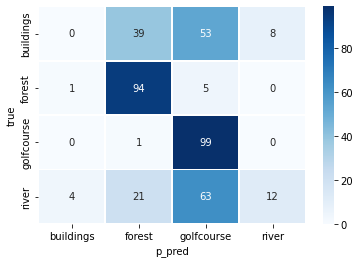

In [13]:
i = 4
print("*****************************************")
print("******** ITERATION "+str(i)+" ************")
eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

preds_df = ucl_v2.predict_model(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen, img_size=WORK_IMG_SIZE,random_seed=101)
print(preds_df.value_counts("correct_p"))
# print(preds_df.value_counts("correct_c"))

print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))

print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
# print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
print("*****************************************")


preds_df["true"] = [label_dict[x] for x in preds_df["true"]] 
preds_df["p_pred"] = [label_dict[x] for x in preds_df["p_pred"]] 

preds_df["correct_p"] = preds_df["p_pred"] == preds_df["true"]
misclassified = preds_df[preds_df["correct_p"] == False]

cm = pd.crosstab(preds_df["true"], preds_df["p_pred"])
f = sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues', linewidth=.5)